In [105]:
import os
import numpy as np
import matplotlib.pyplot as plt

def load(folders):
    return [np.load(f"{f}_train_session.npy") for f in folders]
def plt_setup():
    plt.xlabel('Training Steps [x100000]')
    plt.ylabel('Performance')
    # plt.ylim(0, 100)
    plt.legend()
def plt_mean(datas):
    for i, d in enumerate(datas):
        plt.plot(d.mean(axis=1), label=f'{i}')
def plt_means(data):
    for i, y in enumerate(data.T):
        plt.plot(y, label=f'd = {i+1}')
    plt.xlabel('Training Steps [x100000]')
    plt.ylabel('Performance')
    plt.legend()
    plt.show()


In [106]:
folders = ['models/06_02/PPO_16_35', 'models/06_03/PPO_02_44',
           'models/06_03/PPO_10_00', 'models/06_03/PPO_19_28']
        #    'models/06_08/PPO_13_50']
datas = load(folders)

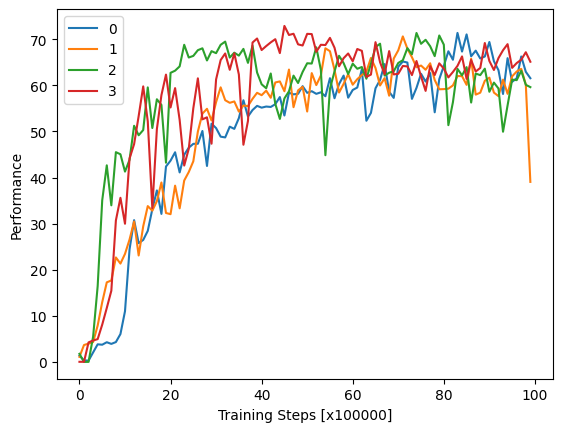

In [107]:
plt_mean(datas)
plt_setup()

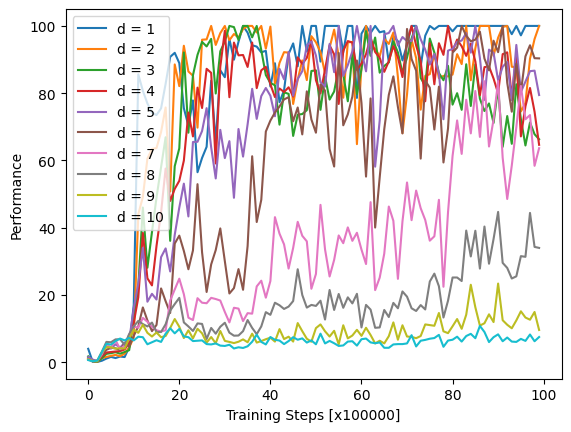

In [108]:
# Score falls with difficulty
plt_means(datas[0])

In [109]:
def plt_score(player):
    plt.plot(player.T, color='r', alpha=0.1)
    plt.xlabel('Difficulty')
    plt.ylabel('Performance')
    plt.title(f'{player.shape[0]} players')
    plt.show()

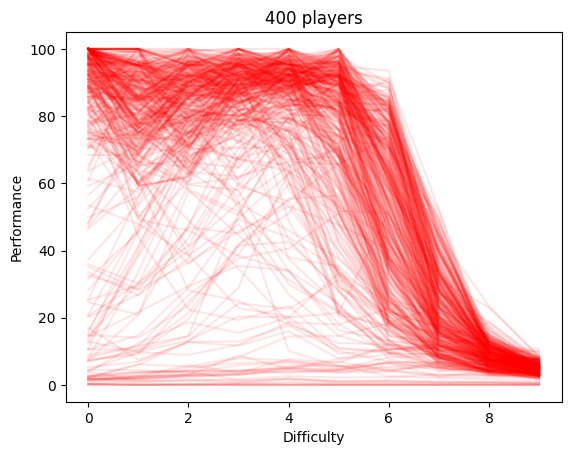

In [110]:
# Stack all players together
all_players = np.vstack(datas)
plt_score(all_players)

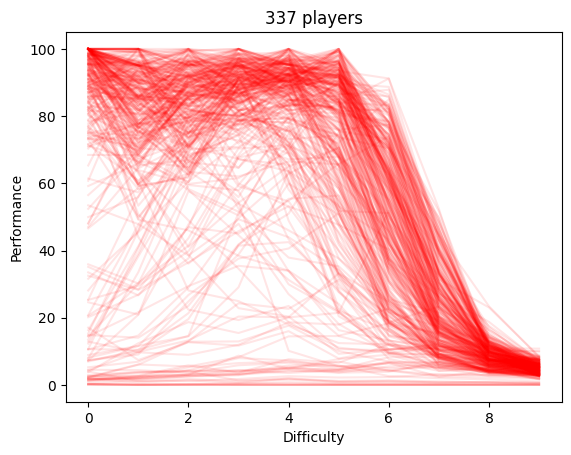

In [111]:
# This tests for non-decreasing values
# np.all(a[:-1] <= a[1:])
# Filter out those that are not non-decreasing
all_players = np.vstack(datas)
all_players = np.array([p for p in all_players if np.all(p[:-1] <= p[1:] + 50)])
plt_score(all_players)

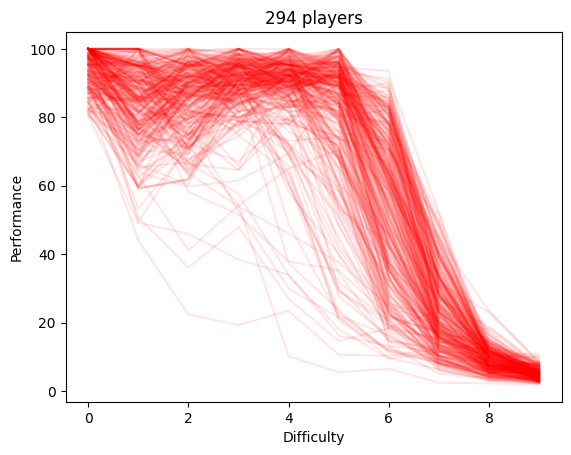

In [112]:
all_players = np.vstack(datas)
all_players = np.array([p for p in all_players if np.all(p[0] >= 80)])
plt_score(all_players)

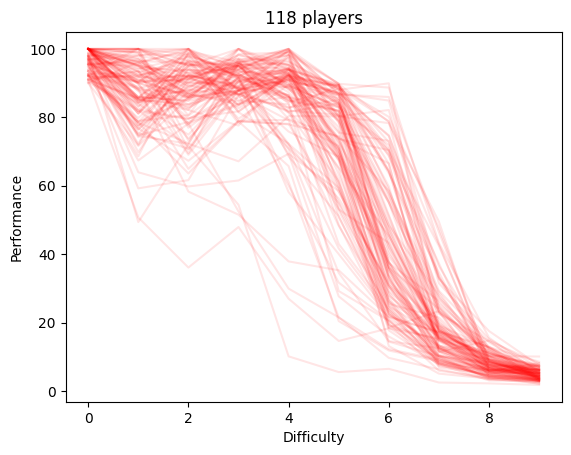

In [113]:
all_players = np.vstack(datas)
all_players = np.array([p for p in all_players if np.all(p[0] >= 90)])
all_players = np.array([p for p in all_players if np.all(p[5] <= 90)])
plt_score(all_players)

A **population trace** is an ordered set of agents by their skill level. Its
a curve indexed by the agents’ id numbers and the co-domain is the skill level of each agent. It is a monotonic growing succession.

$\Delta$ (difference between max and min)

$\Gamma$ (skill density or variety)

Given a population of skills $S$
$$
\Delta = \max(S) - \min(S)\\
\Gamma = \sigma_S
$$

In [114]:
def get_delta(skills):
    return skills[-1] - skills[0]

def get_gamma(skills):    
    return sum([skills[i+1] - skills[i] for i in range(len(skills)-1)]) / get_delta(skills)

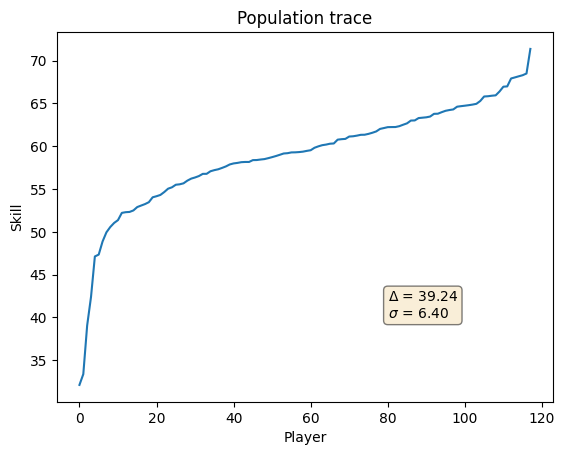

In [115]:
skills = all_players.mean(axis=1)

# Compute difference of max and min
Delta = skills.max() - skills.min()
# Compute variety
Gamma = skills.std()
Delta, Gamma

def plt_pop(pop):
    skills = pop.mean(axis=1)
    skills.sort()
    plt.title(f'Population trace')
    plt.xlabel('Player')
    plt.ylabel('Skill')
    Delta = skills.max() - skills.min()
    Gamma = skills.std()
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # plt.text(30, 30, r'$\sigma$', bbox=props)
    plt.text(80, 40, f'{r'$\Delta$'} = {Delta:.2f}\n{r'$\sigma$'} = {Gamma:.2f}', bbox=props)


    plt.plot(skills)
# Sample every 10th player
# all_players_ = np.vstack((all_players[:50], all_players[50::2]))
plt_pop(all_players)

In [116]:
all_players.shape

(118, 10)

In [117]:
# Collect indices instead
all_players = np.vstack(datas)
indice = np.where((all_players[:, 0] >= 90) & (all_players[:, 5] <= 90))
# indice = np.where((all_players[:, 0] >= 90))# & (all_players[:, 5] <= 90))

# Find corresponding difficulty matric
diff_mat = []
for folder in folders:
    dirs = [folder + "/" + f[:-4] for f in os.listdir(folder) if f.endswith(".npy")]
    dirs.sort(key=lambda x: int(x.split("_")[-3]))
    diff_mat.extend(dirs)

# Filter out
diff_mat = np.array(diff_mat)[indice]

# Now actually load them
diff_mat = [np.load(f + ".npy") for f in diff_mat]
np.array(diff_mat).shape

(118, 10, 10)

## Grid Curve

In [118]:
from scipy.interpolate import interpn
discrete = np.arange(1, 11)
continuous = np.linspace(1, 10, 100)
def interpolate(data, res=100):
    smooth = np.linspace(1, 10, res)
    coords = np.array(np.meshgrid(smooth, smooth)).T.reshape(-1, 2)
    z = interpn((discrete, discrete), data, coords, "cubic").reshape(res, -1)
    return z

In [119]:
Zs = [interpolate(d_mat) for d_mat in diff_mat]
Z = np.mean(Zs, axis=0)
avg_data = np.mean(diff_mat, axis=0)

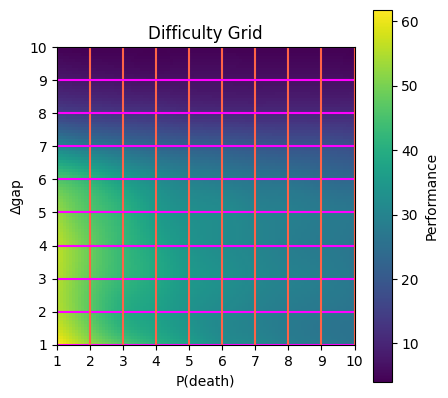

: 

In [132]:
plt.matshow(Z, extent=(1, 10, 1, 10), origin='lower')
plt.colorbar(label='Performance')

constant = 2
c1, c2 = 'magenta', 'tomato'
for c in range(1, 11):
    plt.axhline(c, color=c1)
    plt.axvline(c, color=c2)

plt.gca().xaxis.set_ticks_position('bottom')
# set ticks
plt.xticks(range(1, 11))
plt.yticks(range(1, 11))
plt.xlabel("P(death)")
plt.ylabel("\u0394gap")
plt.title('Difficulty Grid')
plt.show()

In [121]:
# Have to flip x and y for some reason???
hors = []
verts = []
for c in range(1, 11):
    h = np.column_stack((np.full_like(continuous, c), continuous))
    v = np.column_stack((continuous, np.full_like(continuous, c)))
    
    hors.append(interpn((discrete, discrete), avg_data, h, "cubic"))
    verts.append(interpn((discrete, discrete), avg_data, v, "cubic"))


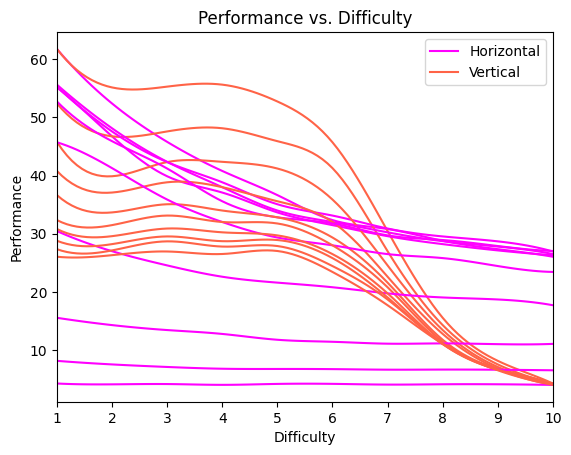

In [122]:
for h, v in zip(hors, verts):
    plt.plot(continuous, h, color=c1)
    plt.plot(continuous, v, color=c2)
plt.xlabel('Difficulty')
plt.ylabel('Performance')
plt.xlim(1, 10)
# plt.ylim(0, max(max(y_pred_1), max(y_pred_2)) + 100)
plt.title('Performance vs. Difficulty')
plt.legend(['Horizontal', 'Vertical'])
plt.show()

In [123]:
# Save selected diff_mat as population
np.save("population", diff_mat)